In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Nastavenie semienka pre opakovateľnosť výsledkov
torch.manual_seed(42)

# Načítanie dát
data = pd.read_excel(r"C:\Users\firda\OneDrive\Študijný materiál\VŠ\2024 LS 2.rocnik\NeuronoveSiete\Zadanie\moje data\15min_dataset_pre_NN.xlsx", sheet_name="Sheet1")

# Definícia hodnôt A a N
data['Class'] = np.where(data['Rozsev 0-5'] <= 12, 'A', 'N')


# Rozdelenie na vstupy (X) a výstupy (y)
X = data.drop(columns=["Rozsev 0-5", "Class"])
y = data["Class"]

# Normalizácia vstupných údajov
X = (X - X.mean()) / X.std()

# Rozdelenie dát na trénovacie, validačné a testovacie sady
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=174)


# Prevod na PyTorch tenzory
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_train = torch.tensor((y_train =='A' ).values, dtype=torch.float32)  # 1 pre A, 0 pre N
y_val = torch.tensor((y_val =='A' ).values, dtype=torch.float32)

# Vytvorenie DataLoader objektov
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)  # pridávame dimenziu pre sekvencie
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val.unsqueeze(1), y_val)  # pridávame dimenziu pre sekvencie
val_loader = DataLoader(val_dataset, batch_size=64)

# Definícia triedy modelu
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Výstupná vrstva pre jednu hodnotu
        self.sigmoid = nn.Sigmoid()  # Sigmoidná aktivačná funkcia
        self.dropout = nn.Dropout(dropout)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out)  
        out = self.fc(out[:, -1, :]) 
        out = self.sigmoid(out)  # Použitie sigmoidnej aktivačnej funkcie
        return out

# Inicializácia modelu
input_size = len(X.columns)
hidden_size = 75
num_layers = 1
dropout = 0.2
model = RNNClassifier(input_size, hidden_size, num_layers, dropout=dropout)

# Definícia straty a optimalizátora
criterion = nn.BCELoss()  # Binárna krížová entropia
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Trénovanie modelu
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels) 
        loss.backward()
        optimizer.step()
        train_loss += criterion(outputs.squeeze(), labels)
        train_loss /= len(train_loader)
    
    # Validácia modelu
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f} , Validation Loss: {val_loss:.4f}")

print('Training finished.')

# Testovanie na testovacej sade
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs.squeeze(), labels).item()
        predicted = (outputs >= 0.4).squeeze().long() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(val_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

c:\Users\firda\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\firda\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/300, Train Loss: 0.1367 , Validation Loss: 0.6747
Epoch 2/300, Train Loss: 0.1333 , Validation Loss: 0.6736
Epoch 3/300, Train Loss: 0.1341 , Validation Loss: 0.6725
Epoch 4/300, Train Loss: 0.1365 , Validation Loss: 0.6714
Epoch 5/300, Train Loss: 0.1360 , Validation Loss: 0.6704
Epoch 6/300, Train Loss: 0.1347 , Validation Loss: 0.6693
Epoch 7/300, Train Loss: 0.1347 , Validation Loss: 0.6682
Epoch 8/300, Train Loss: 0.1351 , Validation Loss: 0.6672
Epoch 9/300, Train Loss: 0.1359 , Validation Loss: 0.6661
Epoch 10/300, Train Loss: 0.1354 , Validation Loss: 0.6651
Epoch 11/300, Train Loss: 0.1356 , Validation Loss: 0.6641
Epoch 12/300, Train Loss: 0.1342 , Validation Loss: 0.6630
Epoch 13/300, Train Loss: 0.1332 , Validation Loss: 0.6620
Epoch 14/300, Train Loss: 0.1303 , Validation Loss: 0.6610
Epoch 15/300, Train Loss: 0.1334 , Validation Loss: 0.6599
Epoch 16/300, Train Loss: 0.1330 , Validation Loss: 0.6589
Epoch 17/300, Train Loss: 0.1319 , Validation Loss: 0.6579
Epoch 

In [2]:
# Prevedenie tenzoru na numpy pole
class_values = data['Class'].to_numpy()

# Výpis obsahu stĺpca 'Class'
print(class_values)

['A' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'N' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'N' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A'
 'A' 'N' 'A' 'N' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'N' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'N' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'N'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'N' 'A

In [3]:
predicted_probabilities = model(X_val.unsqueeze(1)).squeeze().detach().cpu().numpy()

# inicializácia premenných pre maximálne F1 skóre a prahovú hodnotu
max_f1_score = 0
best_threshold = 0

# prechádzanie rôznych prahových hodnôt
for threshold in np.arange(0.1, 1.0, 0.1):
    # binarizácia predikcií na základe prahu
    predicted_classes = (predicted_probabilities >= threshold).astype(int)
    
    # výpočet F1 skóre pre aktuálnu prahovú hodnotu
    f1 = f1_score(y_val, predicted_classes)
    
    # aktualizácia maximálneho F1 skóre a prahovej hodnoty
    if f1 > max_f1_score:
        max_f1_score = f1
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Max F1 score:", max_f1_score)

Best threshold: 0.4
Max F1 score: 0.9090909090909091


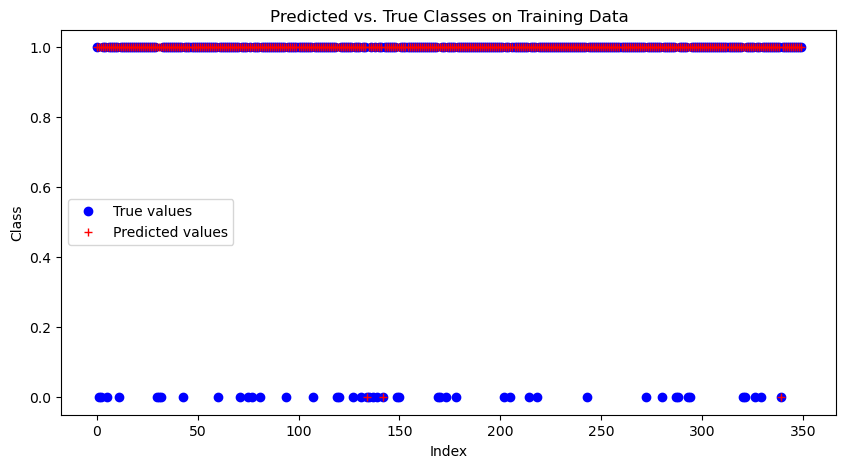

In [4]:
model.eval()

# Predikcia hodnôt pre trénovaciu sadu
predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in train_loader:
        outputs = model(data)
        predicted_classes = (outputs >= 0.4).squeeze().cpu().numpy()  # Prahovanie na pravdepodobnosti
        predicted_values.extend(predicted_classes)
        true_values.extend(labels.cpu().numpy())

# Vykreslenie grafu predikovaných a skutočných hodnôt
plt.figure(figsize=(10, 5))
plt.plot(true_values, 'bo', label="True values")
plt.plot(predicted_values, 'r+', label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Class")
plt.title("Predicted vs. True Classes on Training Data")
plt.legend()
plt.show()

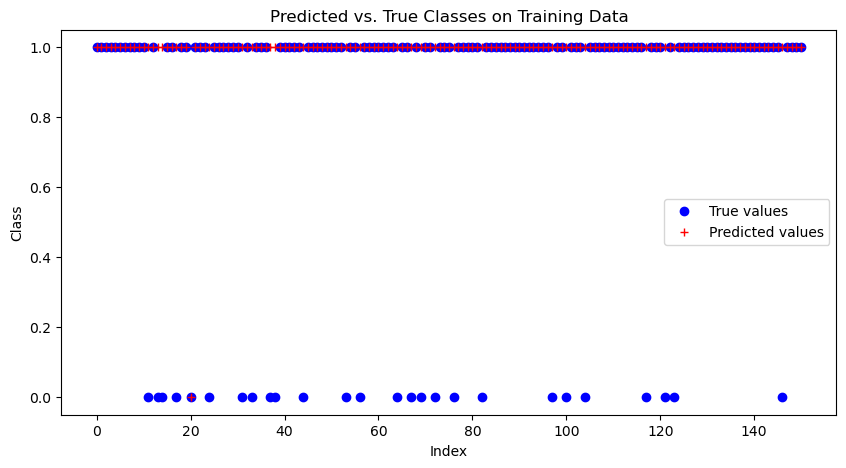

In [5]:
model.eval()

# Predikcia hodnôt pre testovaciu sadu
predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in val_loader:
        
        outputs = model(data)
        predicted_classes = (outputs >= 0.4).squeeze().cpu().numpy()  # Prahovanie na pravdepodobnosti
        predicted_values.extend(predicted_classes)
        true_values.extend(labels.cpu().numpy())

# Vykreslenie grafu predikovaných a skutočných hodnôt
plt.figure(figsize=(10, 5))
plt.plot(true_values, 'bo', label="True values")
plt.plot(predicted_values, 'r+', label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Class")
plt.title("Predicted vs. True Classes on Training Data")
plt.legend()
plt.show()

In [6]:
# Vytvorenie DataFrame zo skutočných a predikovaných hodnôt
df = pd.DataFrame({'True_values': true_values, 'Predicted_values': predicted_values})

# Výpis obsahu tabuľky
df

,True_values,Predicted_values
0,1.0,True
1,1.0,True
2,1.0,True
3,1.0,True
4,1.0,True
...,...,...
146,0.0,True
147,1.0,True
148,1.0,True
149,1.0,True


In [7]:
df.to_csv('predicted_vs_true.csv', index=False)